In [4]:
import json
page_image = "aonids/page3_0.jpeg"
with open("results/surya/aonids/results.json") as f:
    results = json.load(f)

In [11]:
results["page3_0"][0].values()

dict_values([[{'polygon': [[87.0, 57.0], [131.0, 57.0], [131.0, 77.0], [87.0, 77.0]], 'confidence': 0.5566281080245972, 'text': 'TV', 'bbox': [87.0, 57.0, 131.0, 77.0]}, {'polygon': [[86.0, 91.0], [467.0, 96.0], [467.0, 123.0], [86.0, 118.0]], 'confidence': 0.9042366147041321, 'text': 'Надвюсь, что Публикъ прі-', 'bbox': [86.0, 91.0, 467.0, 123.0]}, {'polygon': [[86.0, 131.0], [465.0, 137.0], [464.0, 163.0], [86.0, 157.0]], 'confidence': 0.9067457914352417, 'text': 'ятно будеть найши здѣсь', 'bbox': [86.0, 131.0, 465.0, 163.0]}, {'polygon': [[81.0, 171.0], [465.0, 175.0], [465.0, 202.0], [81.0, 198.0]], 'confidence': 0.8359061479568481, 'text': 'вместь почни веђхь нашихь', 'bbox': [81.0, 171.0, 465.0, 202.0]}, {'polygon': [[83.0, 214.0], [463.0, 214.0], [463.0, 243.0], [83.0, 243.0]], 'confidence': 0.8964934945106506, 'text': 'извђсшныхь (*) Спихо-', 'bbox': [83.0, 214.0, 463.0, 243.0]}, {'polygon': [[83.0, 252.0], [463.0, 257.0], [463.0, 282.0], [82.0, 277.0]], 'confidence': 0.8441348

In [ ]:
import json
from xml.etree.ElementTree import Element, SubElement, tostring
from xml.dom import minidom
import os

def create_mets_xml(page_keys):
    """
    Create METS XML for organizing image and ALTO XML files
    
    Args:
        page_keys: List of page keys (e.g., ['page0_0', 'page1_0', ...])
    """
    # Create root element with namespaces
    mets = Element('mets', {
        'xmlns': 'http://www.loc.gov/METS/',
        'xmlns:xlink': 'http://www.w3.org/1999/xlink'
    })
    
    # Create fileSec
    file_sec = SubElement(mets, 'fileSec')
    
    # Create image fileGrp
    file_grp_img = SubElement(file_sec, 'fileGrp', {'USE': 'image'})
    
    # Add image files
    for idx, page_key in enumerate(page_keys, 1):
        file_elem = SubElement(file_grp_img, 'file', {'ID': f'image{idx}'})
        flocat = SubElement(file_elem, 'FLocat')
        flocat.set('{http://www.w3.org/1999/xlink}href', f'{page_key}.jpeg')
    
    # Create export fileGrp
    file_grp_export = SubElement(file_sec, 'fileGrp', {'USE': 'export'})
    
    # Add ALTO XML files
    for idx, page_key in enumerate(page_keys, 1):
        file_elem = SubElement(file_grp_export, 'file', {'ID': f'export{idx}'})
        flocat = SubElement(file_elem, 'FLocat')
        flocat.set('{http://www.w3.org/1999/xlink}href', f'{page_key}.alto.xml')
    
    # Create structMap
    struct_map = SubElement(mets, 'structMap', {'TYPE': 'physical'})
    doc_div = SubElement(struct_map, 'div', {'TYPE': 'document'})
    
    # Add page divs with file references
    for idx, _ in enumerate(page_keys, 1):
        page_div = SubElement(doc_div, 'div', {'TYPE': 'page'})
        SubElement(page_div, 'fptr', {'FILEID': f'image{idx}'})
        SubElement(page_div, 'fptr', {'FILEID': f'export{idx}'})
    
    # Convert to pretty-printed XML string
    rough_string = tostring(mets, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="  ")

def create_mets_file(json_data, output_dir, output_file='mets.xml'):
    """
    Create METS XML file from OCR JSON data
    
    Args:
        json_data: Dictionary containing OCR data
        output_file: Output METS XML filename
    """
    # Get sorted list of page keys
    page_keys = sorted([k for k in json_data.keys()])
    
    # Create METS XML
    mets_xml = create_mets_xml(page_keys)
    
    # Save to file
    with open(f"{output_dir}/{output_file}", 'w', encoding='utf-8') as f:
        f.write(mets_xml)
    
    print(f"Created METS XML file: {output_file}")

def calculate_baseline(bbox):
    """
    Calculate baseline coordinates at the vertical center of the text
    Args:
        bbox: tuple of (x1, y1, x2, y2)
    Returns:
        string: baseline coordinates in format "x1 y y2 y"
    """
    x1, y1, x2, y2 = bbox
    # Calculate the vertical center
    y_center = y1 + (y2 - y1) // 2
    # For center baseline
    return f"{int(x1)} {int(y_center)} {int(x2)} {int(y_center)}"
    
    # Alternatively, for top baseline:
    # return f"{int(x1)} {int(y1)} {int(x2)} {int(y1)}"

def create_alto_xml(page_key, page_data, i):
    """Create ALTO XML for a single page"""
    # Create root element
    alto = Element('alto', {
        'xmlns:xsi': 'http://www.w3.org/2001/XMLSchema-instance',
        'xmlns': 'http://www.loc.gov/standards/alto/ns-v4#',
        'xsi:schemaLocation': 'http://www.loc.gov/standards/alto/ns-v4# http://www.loc.gov/standards/alto/v4/alto-4-2.xsd'
    })
    
    # Add Description
    description = SubElement(alto, 'Description')
    measurement_unit = SubElement(description, 'MeasurementUnit')
    measurement_unit.text = 'pixel'
    
    # Add sourceImageInformation
    source_image_info = SubElement(description, 'sourceImageInformation')
    filename = SubElement(source_image_info, 'fileName')
    filename.text = f'{page_key}.jpeg'
    
    # Add Tags
    tags = SubElement(alto, 'Tags')
    tag_data = [
        ('BT1', 'Title', 'block type Title'),
        ('BT2', 'Main', 'block type Main'),
        ('BT3', 'Commentary', 'block type Commentary'),
        ('BT4', 'Illustration', 'block type Illustration'),
        ('BT77', 'RunningTitleZone', 'block type RunningTitleZone'),
        ('BT78', 'MainZone', 'block type MainZone'),
        ('LT22', 'default', 'line type default')
    ]
    
    for tag_id, label, description_text in tag_data:
        other_tag = SubElement(tags, 'OtherTag')
        other_tag.set('ID', tag_id)
        other_tag.set('LABEL', label)
        other_tag.set('DESCRIPTION', description_text)
    
    # Create Layout
    layout = SubElement(alto, 'Layout')
    
    # Create Page
    page = SubElement(layout, 'Page')
    if 'image_bbox' in page_data:
        bbox = page_data['image_bbox']
        page.set('WIDTH', str(int(bbox[2])))
        page.set('HEIGHT', str(int(bbox[3])))
    page.set('ID', 'eSc_dummypage_')
    # Extract page number from the key (e.g., 'page3_0' -> '3')
    # page_num = page_key.split('page')[1].split('_')[0]
    page.set('PHYSICAL_IMG_NR', str(i))
    
    # Create PrintSpace
    print_space = SubElement(page, 'PrintSpace')
    print_space.set('HPOS', '0')
    print_space.set('VPOS', '0')
    if 'image_bbox' in page_data:
        print_space.set('WIDTH', str(int(bbox[2])))
        print_space.set('HEIGHT', str(int(bbox[3])))
    
    # Create TextBlock
    text_block = SubElement(print_space, 'TextBlock')
    text_block.set('ID', f'block_{page_key}')
    text_block.set('TAGREFS', 'BT78')
    if 'image_bbox' in page_data:
        text_block.set('HPOS', '0')
        text_block.set('VPOS', '0')
        text_block.set('WIDTH', str(int(bbox[2])))
        text_block.set('HEIGHT', str(int(bbox[3])))
    
    # Add Shape to TextBlock
    shape = SubElement(text_block, 'Shape')
    polygon = SubElement(shape, 'Polygon')
    if 'image_bbox' in page_data:
        width = int(bbox[2])
        height = int(bbox[3])
        points = f"0 0 {width} 0 {width} {height} 0 {height}"
        polygon.set('POINTS', points)
    
    # Process text lines
    for idx, line in enumerate(page_data['text_lines']):
        text_line = SubElement(text_block, 'TextLine')
        text_line.set('ID', f'line_{idx}')
        text_line.set('TAGREFS', 'LT22')
        
        if 'bbox' in line:
            bbox = line['bbox']
            # Use the new baseline calculation
            baseline = calculate_baseline(bbox)
            text_line.set('BASELINE', baseline)
            text_line.set('HPOS', str(int(bbox[0])))
            text_line.set('VPOS', str(int(bbox[1])))
            text_line.set('WIDTH', str(int(bbox[2] - bbox[0])))
            text_line.set('HEIGHT', str(int(bbox[3] - bbox[1])))
        
        # Add Shape to TextLine
        line_shape = SubElement(text_line, 'Shape')
        line_polygon = SubElement(line_shape, 'Polygon')
        if 'polygon' in line:
            points = ' '.join(f"{int(x)} {int(y)}" for x, y in line['polygon'])
            line_polygon.set('POINTS', points)
        elif 'bbox' in line:
            x1, y1, x2, y2 = line['bbox']
            points = f"{x1} {y1} {x2} {y1} {x2} {y2} {x1} {y2}"
            line_polygon.set('POINTS', points)
        
        # Create String element
        string = SubElement(text_line, 'String')
        string.set('CONTENT', line['text'])
        if 'bbox' in line:
            x1, y1, x2, y2 = line['bbox']
            string.set('HPOS', str(int(x1)))
            string.set('VPOS', str(int(y1)))
            string.set('WIDTH', str(int(x2 - x1)))
            string.set('HEIGHT', str(int(y2 - y1)))
    
    # Convert to pretty-printed XML string
    rough_string = tostring(alto, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="  ")

def convert_ocr_to_alto_files(json_data, output_dir='alto_output'):
    """
    Convert OCR JSON data to multiple ALTO XML files
    
    Args:
        json_data: Dictionary containing OCR data
        output_dir: Directory to save the ALTO XML files
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Process each page in the JSON data
    i = 0
    for page_key, page_data_list in json_data.items():
        i += 1
            
        # Get the first (and usually only) item in the page data list
        page_data = page_data_list[0]
        
        # Create ALTO XML for this page
        alto_xml = create_alto_xml(page_key, page_data, i)
        
        # Save to file
        output_file = os.path.join(output_dir, f'{page_key}.alto.xml')
        with open(output_file, 'w', encoding='utf-8') as f:
            f.write(alto_xml)
        
        print(f"Created {output_file}")

# Example usage
if __name__ == "__main__":
    # Load JSON data
    output_dir = 'alto_output'
    with open('results/surya/test/results.json', 'r', encoding='utf-8') as f:
        json_data = json.load(f)
    
    # Convert to multiple ALTO XML files
    convert_ocr_to_alto_files(json_data)
    create_mets_file(json_data, output_dir)
    print("Conversion completed. ALTO XML files have been created in the alto_output directory.")

Created alto_output/0a01cda14c9e.alto.xml
Created alto_output/0a42a1b89286.alto.xml
Created alto_output/0a84c0519e01.alto.xml
Created alto_output/0a5d25a7a970.alto.xml
Created alto_output/0a7e21343997.alto.xml
Created alto_output/0abac74577d4.alto.xml
Created alto_output/0a52b3c904ec.alto.xml
Created alto_output/0b0d2fef5a6e.alto.xml
Created alto_output/0a8adf1df109.alto.xml
Created alto_output/0a8d6b331cef.alto.xml
Created alto_output/0a38626a7e36.alto.xml
Created METS XML file: mets.xml
Conversion completed. ALTO XML files have been created in the alto_output directory.


In [148]:
import pandas as pd
df = pd.read_json("marc_records.json", )
df

,control_number,fields,marc_file,urls,pdf_filename,year
0,RU\NLR\UK\2261,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009800053.mrc,"[http://vivaldi.nlr.ru/lk000006595/view, http:...",lk000006595.pdf,1799
1,RU\NLR\A1\1047,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009671201.mrc,"[http://vivaldi.nlr.ru/bx000016572/view, http:...",bx000016572.pdf,None
2,RU\NLR\A1\22367,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009676829.mrc,"[http://vivaldi.nlr.ru/bx000017981/view, http:...",bx000017981.pdf,1786
3,RU\NLR\UK\68,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009797872.mrc,"[http://vivaldi.nlr.ru/lk000001604/view, http:...",lk000001604.pdf,1732
4,RU\NLR\A1\PETRI\221,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009685259.mrc,"[http://vivaldi.nlr.ru/lk000007262/view, http:...",lk000007262.pdf,1725
...,...,...,...,...,...,...
1206,RU\NLR\UK\87,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009797891.mrc,"[http://vivaldi.nlr.ru/lk000001691/view, http:...",lk000001691.pdf,1743
1207,RU\NLR\A1\26606,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009680925.mrc,"[https://vivaldi.nlr.ru/bx000018867/view, http...",bx000018867.pdf,1786
1208,RU\NLR\UK\3842,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009801625.mrc,"[http://vivaldi.nlr.ru/lk000001475/view, http:...",lk000001475.pdf,1798
1209,RU\NLR\UK\2844,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009800636.mrc,"[http://vivaldi.nlr.ru/lk000003993/view, http:...",lk000003993.pdf,1797


In [149]:
# replace empty year with 1800
df["year"] = df["year"].replace("", 1800)
df["year"] = df["year"].replace("5780", 1800)

In [150]:
df["year"].unique()

array(['1799', None, '1786', '1732', '1725', '1791', '1798', '1789',
       '1794', '1788', '1795', '1768', '1741', '1775', '1776', '1756',
       '1778', '1761', '1796', '1790', '1800', '1726', '1730', '1760',
       '1746', '1797', '1747', '1734', '1767', '1774', '1779', '1777',
       '1749', '1771', '1751', '1752', '1744', '1748', '1792', '1765',
       '1762', '1745', '1759', '1754', '1736', '1782', '1780', '1758',
       '1727', '1770', '1784', '1766', '1755', '1783', '1781', '1735',
       '1793', '1785', '1772', '1801', '1743', '1773', '1769', '1740',
       '1787', '1753', '1757', '1731', '1763', '1750', '1742', '1733',
       '1764', 1800, '1728', '1738', '1729', '1737'], dtype=object)

<Axes: >

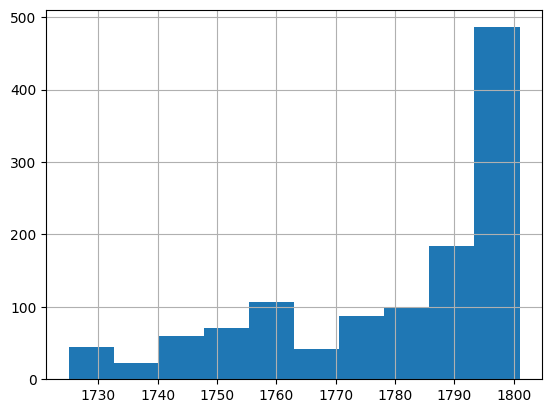

In [151]:
df.dropna(subset=["year"], inplace=True)
df["year"] = df["year"].astype(int)
df["year"].hist()

In [152]:
lk = df[df["pdf_filename"].str.contains("lk")]
lk

,control_number,fields,marc_file,urls,pdf_filename,year
0,RU\NLR\UK\2261,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009800053.mrc,"[http://vivaldi.nlr.ru/lk000006595/view, http:...",lk000006595.pdf,1799
3,RU\NLR\UK\68,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009797872.mrc,"[http://vivaldi.nlr.ru/lk000001604/view, http:...",lk000001604.pdf,1732
4,RU\NLR\A1\PETRI\221,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009685259.mrc,"[http://vivaldi.nlr.ru/lk000007262/view, http:...",lk000007262.pdf,1725
7,RU\NLR\UK\4072,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009801854.mrc,"[http://vivaldi.nlr.ru/lk000005888/view, http:...",lk000005888.pdf,1798
11,RU\NLR\UK\4158,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009801940.mrc,"[http://vivaldi.nlr.ru/lk000005956/view, http:...",lk000005956.pdf,1798
...,...,...,...,...,...,...
1205,RU\NLR\UK\2372,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009800164.mrc,"[http://vivaldi.nlr.ru/lk000006658/view, http:...",lk000006658.pdf,1799
1206,RU\NLR\UK\87,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009797891.mrc,"[http://vivaldi.nlr.ru/lk000001691/view, http:...",lk000001691.pdf,1743
1208,RU\NLR\UK\3842,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009801625.mrc,"[http://vivaldi.nlr.ru/lk000001475/view, http:...",lk000001475.pdf,1798
1209,RU\NLR\UK\2844,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009800636.mrc,"[http://vivaldi.nlr.ru/lk000003993/view, http:...",lk000003993.pdf,1797


In [153]:
ca = df[df["pdf_filename"].str.contains("ca")]
ca

,control_number,fields,marc_file,urls,pdf_filename,year
237,RU\NLR\A1\1342,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009671496.mrc,"[http://vivaldi.nlr.ru/ca000030031/view, http:...",ca000030031.pdf,1800
299,RU\NLR\A1\1343,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009671497.mrc,"[http://vivaldi.nlr.ru/ca000030042/view, http:...",ca000030042.pdf,1799
602,RU\NLR\A1\33388,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009683529.mrc,"[http://vivaldi.nlr.ru/ca000030002/view, http:...",ca000030002.pdf,1789
827,RU\NLR\A1\25023,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009679347.mrc,"[http://vivaldi.nlr.ru/ca000030027/view, http:...",ca000030027.pdf,1750
1050,RU\NLR\A1\7225,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009673051.mrc,"[http://vivaldi.nlr.ru/ca000030043/view, http:...",ca000030043.pdf,1788
1131,RU\NLR\A1\1341,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009671495.mrc,"[http://vivaldi.nlr.ru/ca000030030/view, http:...",ca000030030.pdf,1798


In [154]:
books = df[df["pdf_filename"].str.contains("b")]
books

,control_number,fields,marc_file,urls,pdf_filename,year
2,RU\NLR\A1\22367,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009676829.mrc,"[http://vivaldi.nlr.ru/bx000017981/view, http:...",bx000017981.pdf,1786
5,RU\NLR\A1\22046,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009676513.mrc,"[http://vivaldi.nlr.ru/bx000017556/view, http:...",bx000017556.pdf,1786
6,RU\NLR\A1\7224,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009673050.mrc,"[http://vivaldi.nlr.ru/bx000017854/view, http:...",bx000017854.pdf,1791
8,RU\NLR\A1\20595,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009676052.mrc,"[http://vivaldi.nlr.ru/bx700000141/view, http:...",bx700000141.pdf,1789
9,RU\NLR\A1\2443,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009672461.mrc,"[http://vivaldi.nlr.ru/bx700000092/view, http:...",bx700000092.pdf,1794
...,...,...,...,...,...,...
1197,RU\NLR\A1\22660,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009677121.mrc,"[http://vivaldi.nlr.ru/bx000016247/view, http:...",bx000016247.pdf,1800
1200,RU\NLR\A1\10305,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009673744.mrc,"[http://vivaldi.nlr.ru/bx000016432/view, http:...",bx000016432.pdf,1769
1203,RU\NLR\A1\23354,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009677815.mrc,"[http://vivaldi.nlr.ru/bx000017557/view, http:...",bx000017557.pdf,1789
1204,RU\NLR\A1\12677,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009675125.mrc,"[http://vivaldi.nlr.ru/bx000016509/view, http:...",bx000016509.pdf,1768


In [155]:
books.dropna(subset=["urls"], inplace=True)

/tmp/ipykernel_1414423/2936386733.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books.dropna(subset=["urls"], inplace=True)


In [156]:
# extract the book id, ex. bx000016572 from the list of strings
books["book_id"] = books["urls"].apply(lambda x: x[0].split("/")[-2] + ".pdf")
books

/tmp/ipykernel_1414423/2720540326.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books["book_id"] = books["urls"].apply(lambda x: x[0].split("/")[-2] + ".pdf")


,control_number,fields,marc_file,urls,pdf_filename,year,book_id
2,RU\NLR\A1\22367,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009676829.mrc,"[http://vivaldi.nlr.ru/bx000017981/view, http:...",bx000017981.pdf,1786,bx000017981.pdf
5,RU\NLR\A1\22046,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009676513.mrc,"[http://vivaldi.nlr.ru/bx000017556/view, http:...",bx000017556.pdf,1786,bx000017556.pdf
6,RU\NLR\A1\7224,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009673050.mrc,"[http://vivaldi.nlr.ru/bx000017854/view, http:...",bx000017854.pdf,1791,bx000017854.pdf
8,RU\NLR\A1\20595,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009676052.mrc,"[http://vivaldi.nlr.ru/bx700000141/view, http:...",bx700000141.pdf,1789,bx700000141.pdf
9,RU\NLR\A1\2443,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009672461.mrc,"[http://vivaldi.nlr.ru/bx700000092/view, http:...",bx700000092.pdf,1794,bx700000092.pdf
...,...,...,...,...,...,...,...
1197,RU\NLR\A1\22660,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009677121.mrc,"[http://vivaldi.nlr.ru/bx000016247/view, http:...",bx000016247.pdf,1800,bx000016247.pdf
1200,RU\NLR\A1\10305,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009673744.mrc,"[http://vivaldi.nlr.ru/bx000016432/view, http:...",bx000016432.pdf,1769,bx000016432.pdf
1203,RU\NLR\A1\23354,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009677815.mrc,"[http://vivaldi.nlr.ru/bx000017557/view, http:...",bx000017557.pdf,1789,bx000017557.pdf
1204,RU\NLR\A1\12677,"[{'tag': '001', 'name': 'Control Number', 'val...",NLR009675125.mrc,"[http://vivaldi.nlr.ru/bx000016509/view, http:...",bx000016509.pdf,1768,bx000016509.pdf


In [130]:
check = pd.read_json("download_records.json")
check

,rusmarc_url,downloaded_file
0,https://primo.nlr.ru/07NLR_VU1:default_scope:0...,bx000016235_0001.pdf
1,https://primo.nlr.ru/07NLR_VU1:default_scope:0...,bx000074872_0001.pdf
2,https://primo.nlr.ru/07NLR_VU1:default_scope:0...,bx000016250_0001.pdf
3,https://primo.nlr.ru/07NLR_VU1:default_scope:0...,bx000074823_0001.pdf
4,https://primo.nlr.ru/07NLR_VU1:default_scope:0...,bx000074936_0001.pdf
...,...,...
1143,http://primo.nlr.ru/07NLR_VU1:default_scope:07...,bx000017294_0001.pdf
1144,http://primo.nlr.ru/07NLR_VU1:default_scope:07...,bx000025103_0001.pdf
1145,http://primo.nlr.ru/07NLR_VU1:default_scope:07...,bx000024774_0001.pdf
1146,http://primo.nlr.ru/07NLR_VU1:default_scope:07...,bx000024780_0001.pdf


In [76]:
books = check[check["downloaded_file"].str.contains("b")]
books

,rusmarc_url,downloaded_file
0,https://primo.nlr.ru/07NLR_VU1:default_scope:0...,bx000016235_0001.pdf
1,https://primo.nlr.ru/07NLR_VU1:default_scope:0...,bx000074872_0001.pdf
2,https://primo.nlr.ru/07NLR_VU1:default_scope:0...,bx000016250_0001.pdf
3,https://primo.nlr.ru/07NLR_VU1:default_scope:0...,bx000074823_0001.pdf
4,https://primo.nlr.ru/07NLR_VU1:default_scope:0...,bx000074936_0001.pdf
...,...,...
1142,http://primo.nlr.ru/07NLR_VU1:default_scope:07...,bx700000217_0001.pdf
1143,http://primo.nlr.ru/07NLR_VU1:default_scope:07...,bx000017294_0001.pdf
1144,http://primo.nlr.ru/07NLR_VU1:default_scope:07...,bx000025103_0001.pdf
1145,http://primo.nlr.ru/07NLR_VU1:default_scope:07...,bx000024774_0001.pdf
